# Задание 1


Задание 1. Атаки adversarial на модель
Цель: Демонстрация уязвимости модели к атаке.


﻿﻿1.﻿ ﻿Дана предобученная модель классификации изображений. [здесь].

2. Для данной модели проводим обучение на следующем наборе данных [здесь] или аналог.

﻿3. ﻿Используя библиотеку (например, art, cleverhans), создайте adversarial examples, которые изменяют предсказание модели и подготовьте inference для демонстрации.

In [1]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.4/910.4 kB 11.8 MB/s eta 0:00:00


In [2]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat -q
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat -q

## Загрузка и дообучение

In [3]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

Обработаем датасет, распакуем матлабовские файлы и создадим нужную иерархию папок

In [4]:
train_data = scipy.io.loadmat("/content/train_32x32.mat")
test_data = scipy.io.loadmat("/content/test_32x32.mat")

In [5]:
def process_data(data, output_dir, dataset_type):

    X = np.transpose(data['X'], (3, 0, 1, 2))  # Изменяем размерность
    y = data['y'].flatten()  # Приводим y к одномерному виду
    print("data dimension:")
    print("X: ", X.shape)
    print("y: ", y.shape)
    print("-------------")

    # Создаем необходимые директории
    os.makedirs(os.path.join(output_dir, dataset_type), exist_ok=True)
    for i in range(10):
        os.makedirs(os.path.join(output_dir, dataset_type, f'{i}'), exist_ok=True)

    for i in range(len(X)):
        image = X[i]
        label = y[i]
        # Преобразуем метку 10 в 0
        if label == 10:
            label = 0
        # Определяем путь для сохранения изображения
        image_path = os.path.join(output_dir, dataset_type, f'{label}', f'image_{i}.png')
        # Сохраняем изображение
        cv2.imwrite(image_path, image)

# Обработка обучающих и тестовых данных
output_dir = 'yolo_dataset'

# Обработка обучающих данных
process_data(train_data, output_dir, 'train')

# Обработка тестовых данных как валидационных
process_data(test_data, output_dir, 'val')

data dimension:
X:  (73257, 32, 32, 3)
y:  (73257,)
-------------
data dimension:
X:  (26032, 32, 32, 3)
y:  (26032,)
-------------


Загрузим и дообучим YOLOv8-cls, версию для классификации

In [6]:
from ultralytics import YOLO

model = YOLO('yolov8n-cls.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.31M/5.31M [00:00<00:00, 11.5MB/s]


In [7]:
model.train(data=output_dir, epochs=5, imgsz=32, classes=10, batch = 64)

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=yolo_dataset, epochs=5, time=None, patience=100, batch=64, imgsz=32, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=10, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_

100%|██████████| 5.35M/5.35M [00:00<00:00, 170MB/s]


AMP: checks passed ✅


train: Scanning /content/yolo_dataset/train... 73257 images, 0 corrupt: 100%|██████████| 73257/73257 [00:09<00:00, 7952.63it/s]


train: New cache created: /content/yolo_dataset/train.cache


val: Scanning /content/yolo_dataset/val... 26032 images, 0 corrupt: 100%|██████████| 26032/26032 [00:03<00:00, 7040.57it/s]


val: New cache created: /content/yolo_dataset/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 32 train, 32 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 5 epochs...

      Epoch    GPU_mem       loss  Instances       Size


        1/5     0.151G      2.669         64         32:   1%|          | 7/1145 [00:01<03:04,  6.18it/s]

        1/5     0.151G      2.682         64         32:   1%|▏         | 15/1145 [00:02<01:53,  9.95it/s]
100%|██████████| 755k/755k [00:00<00:00, 27.2MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 204/204 [00:14<00:00, 14.29it/s]


                   all      0.546      0.911

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 204/204 [00:10<00:00, 19.06it/s]

                   all      0.745      0.971



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 204/204 [00:11<00:00, 18.25it/s]

                   all      0.796      0.978



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 204/204 [00:11<00:00, 18.08it/s]


                   all      0.831      0.982

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 204/204 [00:12<00:00, 16.42it/s]

                   all      0.841      0.984



5 epochs completed in 0.204 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,447,690 parameters, 0 gradients, 3.3 GFLOPs
train: /content/yolo_dataset/train... found 73257 images in 10 classes ✅ 
val: /content/yolo_dataset/val... found 26032 images in 10 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 204/204 [00:11<00:00, 17.26it/s]


                   all       0.84      0.984
Speed: 0.0ms preprocess, 0.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a6b4fbf8b50>
curves: []
curves_results: []
fitness: 0.9123578667640686
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.8403887748718262, 'metrics/accuracy_top5': 0.984326958656311, 'fitness': 0.9123578667640686}
save_dir: PosixPath('runs/classify/train')
speed: {'preprocess': 0.0030648583785551197, 'inference': 0.08172739226171849, 'loss': 0.0003182913675290643, 'postprocess': 0.0004500297219312184}
task: 'classify'
top1: 0.8403887748718262
top5: 0.984326958656311

Сохраним и тут же загрузим модель

In [11]:
model.save("data/yolov8n-cls-trained.pt")

In [7]:
from ultralytics import YOLO

model = YOLO('data/yolov8n-cls-trained.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Создание атаки

In [6]:
!pip install adversarial-robustness-toolbox -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.4 MB/s eta 0:00:00


In [8]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import scipy.io
import numpy as np
import os
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
import matplotlib.pyplot as plt
from torchvision import transforms

Возьмем 10 рандомных картинок каждого класса для валидации

In [9]:
import glob
import random

In [10]:
# Функция для загрузки изображений и меток
random.seed(13)
def load_random_images_and_labels(directory, num_samples=1):
    images = []
    images_paths = []
    labels = []
    for label in range(10):
        label_dir = os.path.join(directory, str(label))
        image_paths = glob.glob(os.path.join(label_dir, '*.png'))

        # Выбираем случайные изображения
        selected_image_paths = random.sample(image_paths, min(num_samples, len(image_paths)))

        for image_path in selected_image_paths:
            image = Image.open(image_path).convert('RGB')
            images.append(image)
            images_paths.append(image_path)
            labels.append(label)

    return images, images_paths, labels

# Загрузка случайных изображений и меток
test_images, test_images_paths, test_labels = load_random_images_and_labels(os.path.join(output_dir, "val"))

In [11]:
print(test_labels)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Сохраним на всякий случай их пути в csv и визулизируем

In [12]:
import pandas as pd
# Создание DataFrame для сохранения в CSV
data = {
    'image_path': test_images_paths,
    'label': test_labels
}
df = pd.DataFrame(data)

# Сохранение в CSV
csv_file_path = os.path.join(f'data/val_random_images.csv')
df.to_csv(csv_file_path, index=False)

print(f"Random images saved to {csv_file_path}")

Random images saved to data/val_random_images.csv


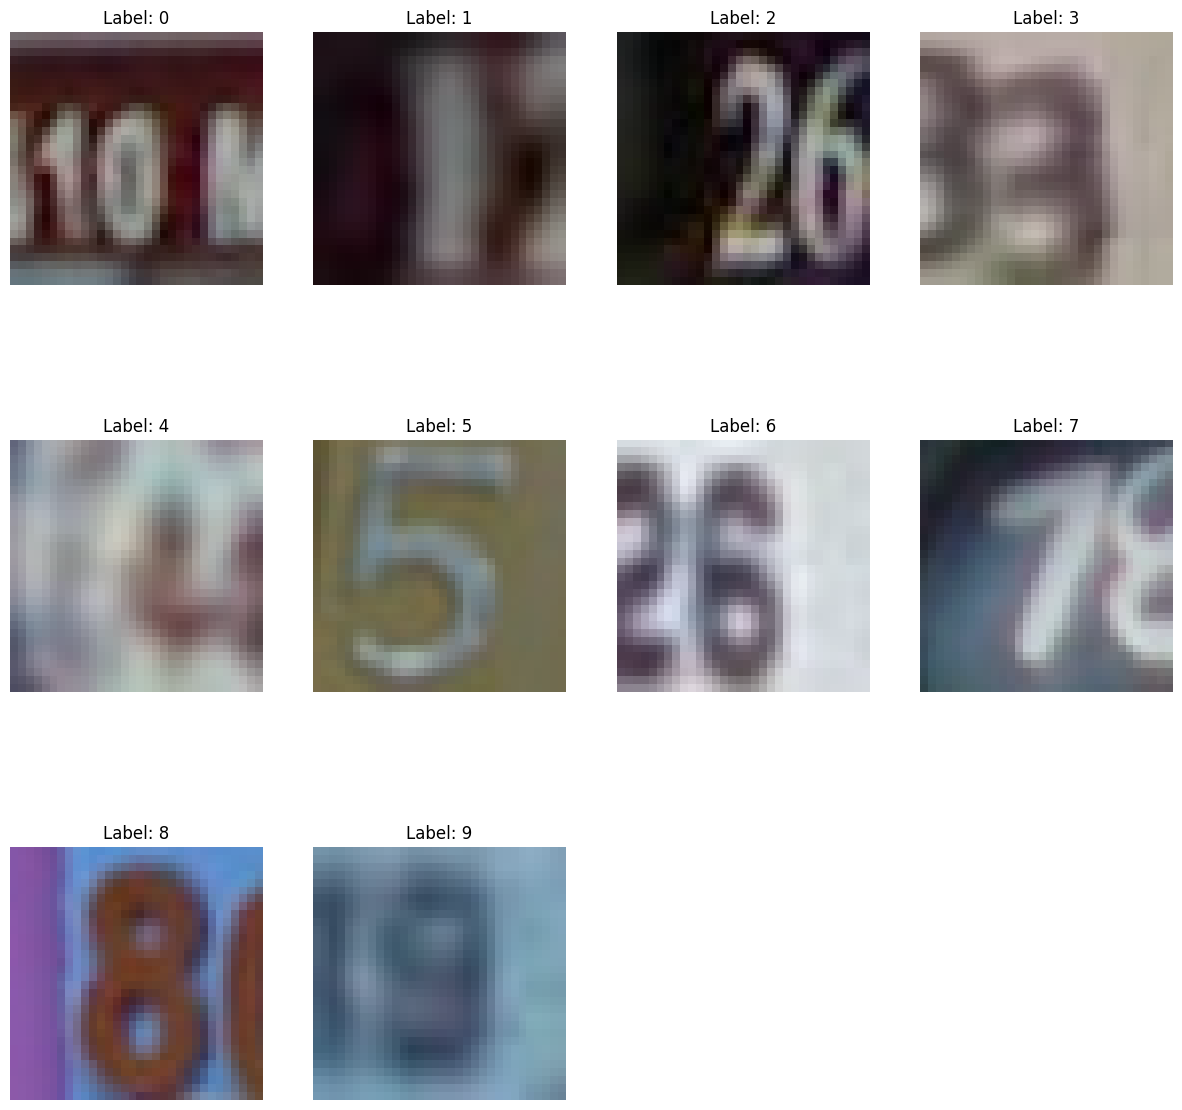

In [13]:
# Демонстрация изображений
def display_images(images, labels, num_images=10):
    # Определяем количество изображений в ряду
    images_per_row = 4
    # Определяем количество строк, необходимых для отображения изображений
    num_rows = (min(num_images, len(images)) + images_per_row - 1) // images_per_row

    plt.figure(figsize=(15, 5 * num_rows))  # Увеличиваем высоту фигуры в зависимости от количества строк
    for i in range(min(num_images, len(images))):
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')  # Отключить оси
    plt.show()

# Вызов функции для отображения первых 10 изображений
display_images(test_images, test_labels, num_images=10)

Посмотрим, как предсказывает данные модель первоначально. Отметим что модель ошибается в картинке, которая должна быть цифрой 3

In [14]:
# Преобразования для изображений
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Применение преобразований к тестовым изображениям
x_test = torch.stack([transform(img) for img in test_images]).numpy()
y_test = np.array(test_labels)

# Функция для предсказания модели
def predict_model(model, images):
    # Преобразуем numpy массивы в тензоры torch.Tensor
    images_tensor = torch.tensor(images, dtype=torch.float32)
    # Перемещаем тензоры на устройство модели (GPU, если доступно)
    device = next(model.model.parameters()).device
    images_tensor = images_tensor.to(device)
    # Получаем предсказания
    results = model(images_tensor)
    predictions = [result.probs.top1 for result in results]
    return predictions

# Получение предсказаний для тестовых изображений
original_predictions = predict_model(model, x_test)


0: 32x32 0 0.76, 9 0.08, 6 0.07, 8 0.05, 3 0.01, 20.5ms
1: 32x32 1 0.95, 4 0.02, 3 0.01, 9 0.01, 8 0.00, 20.5ms
2: 32x32 2 0.51, 1 0.40, 7 0.03, 9 0.02, 3 0.01, 20.5ms
3: 32x32 5 0.41, 8 0.26, 6 0.20, 3 0.07, 9 0.03, 20.5ms
4: 32x32 4 0.63, 3 0.10, 8 0.07, 6 0.06, 5 0.04, 20.5ms
5: 32x32 5 1.00, 3 0.00, 2 0.00, 6 0.00, 1 0.00, 20.5ms
6: 32x32 6 0.83, 8 0.12, 5 0.03, 3 0.01, 9 0.00, 20.5ms
7: 32x32 7 0.96, 1 0.04, 4 0.00, 3 0.00, 2 0.00, 20.5ms
8: 32x32 8 0.96, 3 0.04, 1 0.00, 9 0.00, 6 0.00, 20.5ms
9: 32x32 9 0.98, 8 0.01, 0 0.01, 6 0.00, 5 0.00, 20.5ms
Speed: 0.0ms preprocess, 20.5ms inference, 0.3ms postprocess per image at shape (1, 3, 32, 32)


In [15]:
print(original_predictions)

[0, 1, 2, 5, 4, 5, 6, 7, 8, 9]


YOLO плохо работает с PyTorch, на TochHub есть только YOLOv5, поэтому создадим обертку над моделью для работы с методами PyTorch. Также подготовим классификатор для проведения атаки  

In [16]:
torch_model: torch.nn.modules.container.Sequential = model.model.__dict__["_modules"]["model"]
# Преобразование модели в формат ART
class YOLOv8Wrapper(nn.Module):
    def __init__(self, model):
        super(YOLOv8Wrapper, self).__init__()
        self.model = model

    def forward(self, x):
        predictions = self.model(x)[0]
        return predictions

wrapped_model = YOLOv8Wrapper(torch_model)

classifier = PyTorchClassifier(
    model=wrapped_model,
    loss=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.model.parameters(), lr=0.001),
    clip_values=(0, 1),
    input_shape=(3, 32, 32),
    nb_classes=10,
    preprocessing_defences=None,
    postprocessing_defences=None,
)

In [17]:
print (len(x_test))

10


In [18]:
print(y_test)

[0 1 2 3 4 5 6 7 8 9]


Fast Gradient Method представляет собой метод первой порядка, который добавляет небольшое возмущение к входным данным в направлении градиента функции потерь по отношению к входу. Это позволяет создавать примеры, которые остаются практически незаметными для человека, но вызывают ошибку в работе модели. Используем этот метод

In [19]:
# Выбор атаки
attack = FastGradientMethod(estimator=classifier, eps=0.1)

# Создание adversarial examples
x_test_adv = attack.generate(x=x_test)

# Получение предсказаний для adversarial examples
adversarial_predictions = predict_model(model, x_test_adv)


0: 32x32 4 0.21, 3 0.15, 1 0.14, 5 0.13, 6 0.08, 2.9ms
1: 32x32 4 0.18, 1 0.16, 8 0.12, 2 0.10, 0 0.08, 2.9ms
2: 32x32 1 0.79, 4 0.07, 7 0.03, 0 0.02, 2 0.02, 2.9ms
3: 32x32 1 0.18, 8 0.16, 3 0.15, 4 0.13, 2 0.10, 2.9ms
4: 32x32 0 0.15, 5 0.13, 3 0.11, 8 0.11, 4 0.11, 2.9ms
5: 32x32 1 0.17, 2 0.15, 8 0.14, 3 0.13, 4 0.12, 2.9ms
6: 32x32 3 0.61, 5 0.09, 8 0.08, 2 0.07, 7 0.04, 2.9ms
7: 32x32 1 0.30, 4 0.22, 8 0.07, 0 0.07, 7 0.07, 2.9ms
8: 32x32 1 0.24, 4 0.20, 2 0.12, 8 0.10, 7 0.08, 2.9ms
9: 32x32 1 0.30, 4 0.13, 8 0.10, 7 0.10, 6 0.08, 2.9ms
Speed: 0.0ms preprocess, 2.9ms inference, 0.3ms postprocess per image at shape (1, 3, 32, 32)


In [20]:
print(adversarial_predictions)

[4, 4, 1, 1, 0, 1, 3, 1, 1, 1]


Выведем оригинальные и новые предсказания

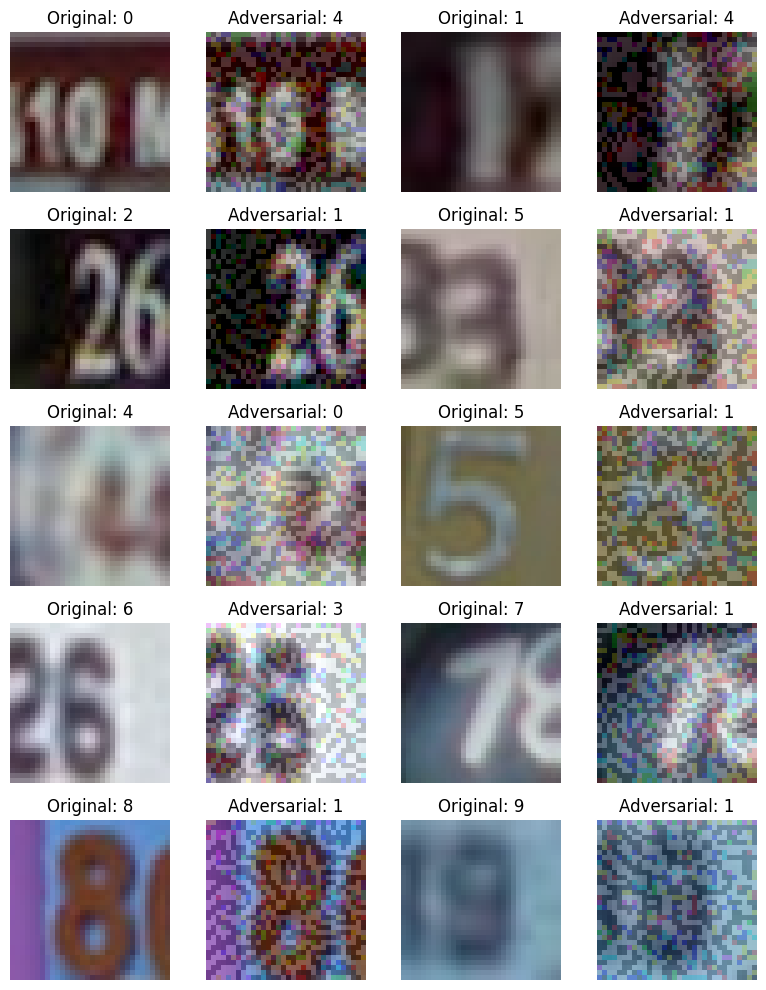

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Функция для отображения изображений по две пары (оригинальное и обработанное) в каждом ряду
def plot_image_pairs(original_images, adversarial_images, original_titles, adversarial_titles, n_cols=2):
    n_images = len(original_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols * 2, figsize=(4 * n_cols, 2 * n_rows))

    for i in range(n_images):
        row = i // n_cols
        col = i % n_cols

        # Оригинальное изображение
        ax_original = axes[row, col * 2]
        ax_original.imshow(original_images[i].transpose(1, 2, 0))  # Перестановка каналов для отображения
        ax_original.set_title(original_titles[i])
        ax_original.axis('off')

        # Обработанное изображение
        ax_adversarial = axes[row, col * 2 + 1]
        ax_adversarial.imshow(adversarial_images[i].transpose(1, 2, 0))  # Перестановка каналов для отображения
        ax_adversarial.set_title(adversarial_titles[i])
        ax_adversarial.axis('off')

    plt.tight_layout()
    plt.show()

# Выбор первых 10 изображений для демонстрации
original_images = x_test[:10]
adversarial_images = x_test_adv[:10]
original_preds = original_predictions[:10]
adversarial_preds = adversarial_predictions[:10]

# Подготовка заголовков для изображений
original_titles = [f'Original: {pred}' for pred in original_preds]
adversarial_titles = [f'Adversarial: {pred}' for pred in adversarial_preds]

# Построение графиков
plot_image_pairs(original_images, adversarial_images, original_titles, adversarial_titles)

Качество предсказаний рухнуло, модель сильно сдвинулась в сторону единицы, хотя для человеческого глаза в основном цифры остались заметны. Атака явно успешна

# Задание 2

Основная проблема задания - YOLO и SVHN не соответствуют API PyTorch, на адаптацию и дебаг уходит много времени, код получается сложным и запутанным. Поэтому я решил сделать просто - аугментированную и атакованную копию исходного датасета, чтобы на нем дообучить модель простым методом .train и посмотреть на результат. Выберу по 2000 картинок каждого класса, итого дважды по 20 тысяч, первые 20 тысяч атакую, вторые 20 тысяч аугментирую. Потом сложу все в один датасет и дообучу модель

In [22]:
random.seed(13)

In [23]:
aug_images, _, aug_labels = load_random_images_and_labels(os.path.join(output_dir, "train"), 2000)

In [24]:
att_images, _, att_labels = load_random_images_and_labels(os.path.join(output_dir, "train"), 2000)

In [25]:
print(len(aug_labels), len(att_labels))

20000 20000


In [26]:
att_images = torch.stack([transform(img) for img in att_images]).numpy()

In [66]:
torch_model: torch.nn.modules.container.Sequential = model.model.__dict__["_modules"]["model"]
# Преобразование модели в формат ART
class YOLOv8Wrapper(nn.Module):
    def __init__(self, model):
        super(YOLOv8Wrapper, self).__init__()
        self.model = model

    def forward(self, x):
        predictions = self.model(x)[0]
        return predictions

wrapped_model = YOLOv8Wrapper(torch_model)

classifier = PyTorchClassifier(
    model=wrapped_model,
    loss=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.model.parameters(), lr=0.001),
    clip_values=(0, 1),
    input_shape=(3, 32, 32),
    nb_classes=10,
    preprocessing_defences=None,
    postprocessing_defences=None,
)
# Выбор атаки
attack = FastGradientMethod(estimator=classifier, eps=0.1)

# Создание adversarial examples
x_train_adv = attack.generate(x=att_images)

In [27]:
# Создание adversarial examples
x_train_adv = attack.generate(x=att_images)

In [28]:
# Сохранение adversarial examples
os.makedirs(os.path.join(output_dir, 'train_adv'), exist_ok=True)
for i in range(10):
    os.makedirs(os.path.join(output_dir, 'train_adv', f'{i}'), exist_ok=True)

for i, adv_image in enumerate(x_train_adv):
    label = att_labels[i]
    image_path = os.path.join(output_dir, 'train_adv', f'{label}', f'adv_image_{i}.png')
    adv_image_np = (adv_image * 255).astype(np.uint8)
    adv_image_pil = Image.fromarray(adv_image_np.transpose(1, 2, 0))
    adv_image_pil.save(image_path)

In [29]:
# Определяем трансформации для аугментации
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),          # Случайное горизонтальное отражение
    transforms.RandomRotation(10),              # Случайный поворот на 10 градусов
    transforms.RandomCrop(32, padding=4),      # Случайное обрезание с заполнением
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Изменение яркости, контрастности и насыщенности
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Случайные смещения
    transforms.RandomVerticalFlip(),             # Случайное вертикальное отражение
])

In [30]:
# Загрузка случайных изображений для аугментации
aug_images, _, aug_labels = load_random_images_and_labels(os.path.join(output_dir, "train"), 2000)

# Применение аугментаций
augmented_images = []
for img in aug_images:
    augmented_img = augment_transform(img)#.numpy()
    augmented_images.append(augmented_img)

# Сохранение аугментированных примеров
os.makedirs(os.path.join(output_dir, 'train_aug'), exist_ok=True)
for i in range(10):
    os.makedirs(os.path.join(output_dir, 'train_aug', f'{i}'), exist_ok=True)

for i, aug_image in enumerate(augmented_images):
    label = aug_labels[i]
    image_path = os.path.join(output_dir, 'train_aug', f'{label}', f'aug_image_{i}.png')

    # Сохраняем изображение напрямую
    aug_image.save(image_path)

In [31]:
import os
import shutil
# Путь к новым данным
new_data_dir = os.path.join('new_yolo_dataset', 'train')
# Создаем директорию для новых данных
os.makedirs(new_data_dir, exist_ok=True)

# Функция для копирования изображений из одной директории в другую
def copy_images(src_dir, dest_dir):
    for label in range(10):  # Предполагаем, что классы от 0 до 9
        src_label_dir = os.path.join(src_dir, str(label))
        dest_label_dir = os.path.join(dest_dir, str(label))

        # Создаем директорию для класса, если она не существует
        os.makedirs(dest_label_dir, exist_ok=True)

        # Копируем все файлы из исходной директории в целевую
        if os.path.exists(src_label_dir):
            for file_name in os.listdir(src_label_dir):
                src_file_path = os.path.join(src_label_dir, file_name)
                dest_file_path = os.path.join(dest_label_dir, file_name)
                shutil.copy(src_file_path, dest_file_path)
# Копирование изображений из train_aug и train_adv в new_yolo_data/train
copy_images(os.path.join(output_dir, 'train_aug'), new_data_dir)
copy_images(os.path.join(output_dir, 'train_adv'), new_data_dir)
new_data_dir = os.path.join('new_yolo_dataset', 'val')
copy_images(os.path.join(output_dir, 'val'), new_data_dir)

In [32]:
model.train(data='new_yolo_dataset', epochs=5, imgsz=32, classes=10, batch = 64)

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=classify, mode=train, model=data/yolov8n-cls-trained.pt, data=new_yolo_dataset, epochs=5, time=None, patience=100, batch=64, imgsz=32, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=10, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

train: Scanning /content/new_yolo_dataset/train... 40000 images, 0 corrupt: 100%|██████████| 40000/40000 [00:05<00:00, 6802.28it/s]


train: New cache created: /content/new_yolo_dataset/train.cache


val: Scanning /content/new_yolo_dataset/val... 26032 images, 0 corrupt: 100%|██████████| 26032/26032 [00:03<00:00, 7329.32it/s]


val: New cache created: /content/new_yolo_dataset/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 32 train, 32 val
Using 0 dataloader workers
Logging results to runs/classify/train
Starting training for 5 epochs...

      Epoch    GPU_mem       loss  Instances       Size


        1/5         0G      2.351         64         32:   0%|          | 2/625 [00:00<03:29,  2.98it/s]

        1/5         0G       2.34         64         32:   1%|          | 4/625 [00:01<02:53,  3.57it/s]
100%|██████████| 755k/755k [00:00<00:00, 11.8MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 204/204 [00:26<00:00,  7.69it/s]


                   all      0.606      0.932

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 204/204 [00:26<00:00,  7.80it/s]


                   all      0.635      0.943

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 204/204 [00:26<00:00,  7.75it/s]

                   all      0.627       0.95



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 204/204 [00:26<00:00,  7.72it/s]


                   all       0.64      0.957

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 204/204 [00:26<00:00,  7.61it/s]

                   all      0.669       0.96



5 epochs completed in 0.262 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 73 layers, 1,447,690 parameters, 0 gradients, 3.3 GFLOPs
train: /content/new_yolo_dataset/train... found 40000 images in 10 classes ✅ 
val: /content/new_yolo_dataset/val... found 26032 images in 10 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 204/204 [00:25<00:00,  8.06it/s]


                   all      0.669       0.96
Speed: 0.0ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c7e6f9639d0>
curves: []
curves_results: []
fitness: 0.814305454492569
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.6687154173851013, 'metrics/accuracy_top5': 0.9598954916000366, 'fitness': 0.814305454492569}
save_dir: PosixPath('runs/classify/train')
speed: {'preprocess': 0.00013478819255676456, 'inference': 0.4301523055924766, 'loss': 1.0422570029870087e-05, 'postprocess': 2.8492632129108827e-05}
task: 'classify'
top1: 0.6687154173851013
top5: 0.9598954916000366

Общее качество модели немного улучшилось, выросло accuracy, снизился loss

In [33]:
model.save("data/yolov8n-cls-trained-aug-att.pt")

In [35]:
model = YOLO("data/yolov8n-cls-trained-aug-att.pt")


0: 32x32 4 0.23, 9 0.22, 0 0.19, 6 0.09, 8 0.09, 1.5ms
1: 32x32 1 0.62, 7 0.10, 4 0.07, 9 0.06, 3 0.04, 1.5ms
2: 32x32 1 0.22, 8 0.18, 6 0.11, 3 0.11, 4 0.10, 1.5ms
3: 32x32 8 0.42, 3 0.24, 5 0.10, 6 0.08, 9 0.06, 1.5ms
4: 32x32 0 0.23, 4 0.22, 9 0.13, 6 0.09, 3 0.07, 1.5ms
5: 32x32 5 0.21, 3 0.16, 2 0.16, 7 0.10, 9 0.10, 1.5ms
6: 32x32 8 0.44, 6 0.28, 3 0.14, 5 0.14, 9 0.01, 1.5ms
7: 32x32 0 0.22, 6 0.15, 9 0.12, 7 0.11, 8 0.08, 1.5ms
8: 32x32 8 0.35, 6 0.17, 7 0.11, 3 0.10, 0 0.10, 1.5ms
9: 32x32 0 0.37, 9 0.20, 6 0.17, 8 0.14, 5 0.03, 1.5ms
Speed: 0.0ms preprocess, 1.5ms inference, 0.0ms postprocess per image at shape (1, 3, 32, 32)


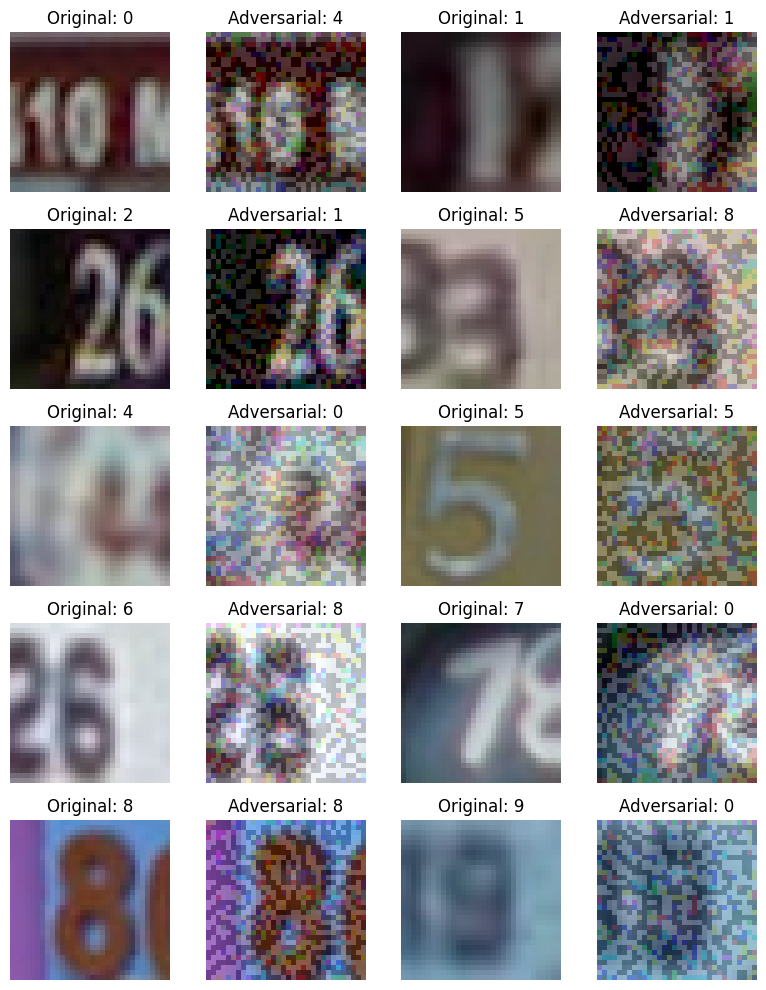

In [36]:
# Получение предсказаний для adversarial examples
adversarial_predictions = predict_model(model, x_test_adv)
# Выбор первых 10 изображений для демонстрации
original_images = x_test[:10]
adversarial_images = x_test_adv[:10]
original_preds = original_predictions[:10]
adversarial_preds = adversarial_predictions[:10]

# Подготовка заголовков для изображений
original_titles = [f'Original: {pred}' for pred in original_preds]
adversarial_titles = [f'Adversarial: {pred}' for pred in adversarial_preds]

# Построение графиков
plot_image_pairs(original_images, adversarial_images, original_titles, adversarial_titles)

Хорошего качества достичь не удалось, но каечство заметно выросло, кое-что теперь предсказывается правильно. Возможно, на лучших картинках предсказания будут идеальными, возможно стоит расширить датасет для дообучения. Но точно можно сказать, что метод помогает бороться с атакой, а также позволяет улучшить общее качество модели